# <center> Akilhoussen Houzefa ONALY</center>

# <center><font color=red>Classification musicale à l'aide de Scikit-learn</font></center>

##  Extraction des descripteurs :

Tout d'abord, on importe les différentes données à l'aide de la méthode "loadtxt" de numpy et d'une fonction readfile :

In [39]:
import numpy as np
import matplotlib.pyplot as plt

donnees_app=np.loadtxt("donnees_app.txt")
donnees_test=np.loadtxt("donnees_test.txt")
classes=['classique','disco','jazz','rock']

def readfile(nom):
    with open(nom,'r') as f:
        data=f.read().splitlines()
    return np.array(data)

app_noms=readfile("noms_app.txt")
app_classes=readfile("classes_app.txt")
test_noms=readfile("noms_test.txt")
test_classes=readfile("classes_test.txt")

On peut alors implémenter les différentes fonctions qui permettront de créer le vecteur des descripteurs pour chaque musique.

In [40]:
def rms(y): #calcule et retourne la RMS d'un vecteur
    y=np.array(y)
    return np.sqrt(sum(y*y)/len(y))

def enveloppe_energie(x,taille): 
    
    # Cette fonction prend en paramètres un vecteur contenant les valeurs 
    # d’amplitudes brutes d’un signal sonore, 
    # ainsi que la taille de la fenêtre temporelle utilisée 
    # (caractérisée par son nombre d’échantillons). 
    # Elle renvoie l’enveloppe d’énergie qui est un vecteur 
    # contenant les valeurs de RMS calculées pour chaque fenêtre. 
    # Un taux de recouvrement de chaque fenêtre de 50% est utilisé.
    
    n=len(x)
    z=[]
    i=0
    while (i+taille)<n:
        a=rms(x[i:i+taille])
        z.append(a)
        i=int(i+taille/2)
    return np.array(z)

#--------------------------------
# On fixe la taille de la fenêtre :

taille_f =  100
#--------------------------------

def centroide_temporel(x):
    e=enveloppe_energie(x,taille_f)
    ind=np.arange(1,len(e)+1)
    return sum(e*ind)/sum(e)

def energie_globale(x): 
    e=enveloppe_energie(x,taille_f)
    return np.mean(e)

def duree_effective(x,p_seuil): 
    
    # calcule la durée effective à partir d'un seuil (en % du maximum)
    # la durée est exprimée en nombre d'éléments supérieurs stricts au seuil
    
    e=enveloppe_energie(x,taille_f)
    m=max(e)
    seuil=p_seuil*m
    n=np.nonzero(e>seuil)
    return n[0].shape[0]

#----------------------------------
# On fixe le pourcentage seuil à 20% 
# pour la durée effective :

p_s =  0.2
#-----------------------------------

def zcr(x): 
    
    # calcule le taux de passage par zéro
    
    n=len(x)
    A=np.sign(x[:-1])
    B=np.sign(x[1:])
    return 0.5*sum((A-B))

def vecteur_descripteurs(x): 
    
    #renvoie le vecteur des descripteurs pour un vecteur x d'amplitudes sonores 
    
    e=energie_globale(x)
    c=centroide_temporel(x)
    d=duree_effective(x,p_s)
    z=zcr(x)
    return np.array([e,c,d,z])

def descripteurs_app(): 
    
    # Cette fonction calcule le vecteur des descripteurs 
    # pour chaque musique de "donnees_app.txt"
    # et retourne le résultat 
    # sous forme de tableau numpy de taille 24x4
    
    res=np.zeros([24,4])
    for k in range(24):
        v=vecteur_descripteurs(donnees_app[k,:])
        res[k,:]=v
    return res

def normalisation_app(): 
    
    # Cette fonction permet de normaliser les descripteurs 
    # pour chaque musique de "donnees_app.txt"
    
    d=descripteurs_app()
    moy=d.mean(0)
    ec=d.std(0)
    return (d-moy)/ec

def descripteurs_test(): 
    
    # Cette fonction calcule le vecteur des descripteurs 
    # pour chaque musique de "donnees_test.txt"
    # et retourne le résultat 
    # sous forme de tableau numpy de taille 24x4
    
    res=np.zeros([24,4])
    for k in range(24):
        v=vecteur_descripteurs(donnees_test[k,:])
        res[k,:]=v
    return res

def normalisation_test():
    
    # Cette fonction permet de normaliser les descripteurs 
    # pour chaque musique de "donnees_test.txt"
    # on normalise en utilisant les moyennes et écarts-types
    # des descripteurs de "donnees_app.txt"
    
    d=descripteurs_app()
    moy=d.mean(0)
    ec=d.std(0)
    r=descripteurs_test()
    return (r-moy)/ec

##  Apprentissage avec Scikit-learn :

In [41]:
X_train=normalisation_app()
X_test=normalisation_test()
Y_train=app_classes
Y_test=test_classes

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
neigh

KNeighborsClassifier(n_neighbors=3)

In [44]:
yhat = neigh.predict(X_test)
yhat

array(['3', '1', '1', '2', '1', '1', '2', '2', '2', '2', '2', '2', '3',
       '3', '2', '1', '3', '3', '4', '2', '1', '2', '1', '3'], dtype='<U1')

##  Calcul de la précision :

In [52]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, yhat))

Train set Accuracy:  0.5416666666666666
Test set Accuracy:  0.625


In [46]:
Ks = 24
mean_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh2 = KNeighborsClassifier(n_neighbors = n).fit(X_train,Y_train)
    yhat2=neigh2.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(Y_test, yhat2)

mean_acc

array([0.5       , 0.45833333, 0.625     , 0.54166667, 0.45833333,
       0.58333333, 0.45833333, 0.54166667, 0.5       , 0.54166667,
       0.45833333, 0.41666667, 0.33333333, 0.20833333, 0.25      ,
       0.33333333, 0.375     , 0.375     , 0.45833333, 0.45833333,
       0.41666667, 0.41666667, 0.375     ])

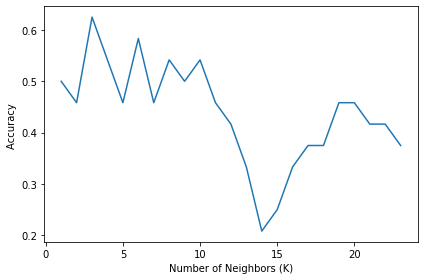

In [47]:
import matplotlib.pyplot as plt
plt.plot(range(1,Ks),mean_acc)
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [48]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.625 with k= 3


##  Prédiction :

In [54]:
def prediction(titre):
    n=np.where(test_noms==titre)
    m=int(yhat[n])
    text='Le genre le plus probable pour '+titre+' est : '
    return text+classes[m-1]
    

In [53]:
print(prediction('mozart-figaro003'))

Le genre le plus probable pour mozart-figaro003 est : classique
